In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!nvidia-smi

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Feb 18 14:36:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
data1 = pd.read_csv('/kaggle/input/divided/reduced_memory_first_part.csv')
data1 = data1.drop(columns=['Unnamed: 0', 'monthly_sales', 'date', 'item_cnt_day'])
data1 = reduce_mem_usage(data1)

Memory usage after optimization is: 264.90 MB
Decreased by 83.5%


In [5]:
data2 = pd.read_csv('/kaggle/input/divided/reduced_memory_second_part.csv')
data2= data2.drop(columns=['Unnamed: 0', 'monthly_sales', 'date', 'item_cnt_day'])
data2 = reduce_mem_usage(data2)

Memory usage after optimization is: 273.99 MB
Decreased by 81.5%


In [6]:
data = pd.concat([data1, data2])
del data1, data2

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ModelValidator:
    def __init__(self, train, dev, target_name):
        self.train_x = train.drop([target_name], axis=1) 
        self.train_y = train[target_name]
        
        self.dev_x = dev.drop([target_name], axis=1)
        self.dev_y = dev[target_name]
        
        self.model = None

    def get_model(self):
        return self.model
    
    def get_dev(self):
        return self.dev_x, self.dev_y
    
    def get_train(self):
        return self.train_x, self.train_y
    
    def train_model(self):
        self.model.fit(self.train_x,self.train_y,eval_metric="rmse")
        y_pred = self.model.predict(self.dev_x)
        print(f'\nMSE : {mean_squared_error(self.dev_y, y_pred)}\nMAE : {mean_absolute_error(self.dev_y, y_pred)}\n R2 : {r2_score(self.dev_y, y_pred)}')

In [8]:
#mv = ModelValidator(data[data.date_block_num<=32], data[(data.date_block_num>32)&(data.date_block_num<=33)], 'item_cnt_month')
#kaggle = data[data.date_block_num==34].drop(['item_cnt_month'], axis=1)

#train_x, train_y = mv.get_train()
#test_x, test_y = mv.get_dev()
#del data
train = data[data.date_block_num <= 30]
test = data[(data.date_block_num > 30)&(data.date_block_num <= 33)]
train_x = train.drop(columns=['item_cnt_month'])
train_y = train['item_cnt_month']

test_x = test.drop(columns=['item_cnt_month'])
test_y = test['item_cnt_month']

### Feature importance

In [9]:
def plot_feature_importance_layer(model, train_x, name):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    feature_importances_df = pd.DataFrame({'feature': train_x.columns[sorted_idx], 'importance': feature_importances[sorted_idx]})
    plt.figure(figsize=(15, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances_df)
    plt.title(name)
    plt.show()

#### Before optimization

In [10]:
#XGBoost
import xgboost as xgb
xgbr = xgb.XGBRegressor(tree_method='gpu_hist')

xgbr.fit(train_x, train_y)

#Catboost
from catboost import CatBoostRegressor
catboostR = CatBoostRegressor(task_type='GPU')
catboostR.fit(train_x, train_y)

Learning rate set to 0.14273
0:	learn: 2.5077305	total: 135ms	remaining: 2m 14s
1:	learn: 2.3631365	total: 258ms	remaining: 2m 8s
2:	learn: 2.2461721	total: 374ms	remaining: 2m 4s
3:	learn: 2.1505819	total: 518ms	remaining: 2m 9s
4:	learn: 2.0747643	total: 658ms	remaining: 2m 10s
5:	learn: 2.0180277	total: 797ms	remaining: 2m 12s
6:	learn: 1.9631790	total: 918ms	remaining: 2m 10s
7:	learn: 1.9228681	total: 1.03s	remaining: 2m 7s
8:	learn: 1.8895088	total: 1.18s	remaining: 2m 10s
9:	learn: 1.8629762	total: 1.32s	remaining: 2m 10s
10:	learn: 1.8421108	total: 1.45s	remaining: 2m 10s
11:	learn: 1.8196151	total: 1.57s	remaining: 2m 9s
12:	learn: 1.8030806	total: 1.74s	remaining: 2m 12s
13:	learn: 1.7884760	total: 1.88s	remaining: 2m 12s
14:	learn: 1.7779259	total: 2.03s	remaining: 2m 13s
15:	learn: 1.7679965	total: 2.17s	remaining: 2m 13s
16:	learn: 1.7608208	total: 2.31s	remaining: 2m 13s
17:	learn: 1.7539109	total: 2.45s	remaining: 2m 13s
18:	learn: 1.7466085	total: 2.58s	remaining: 2m 13

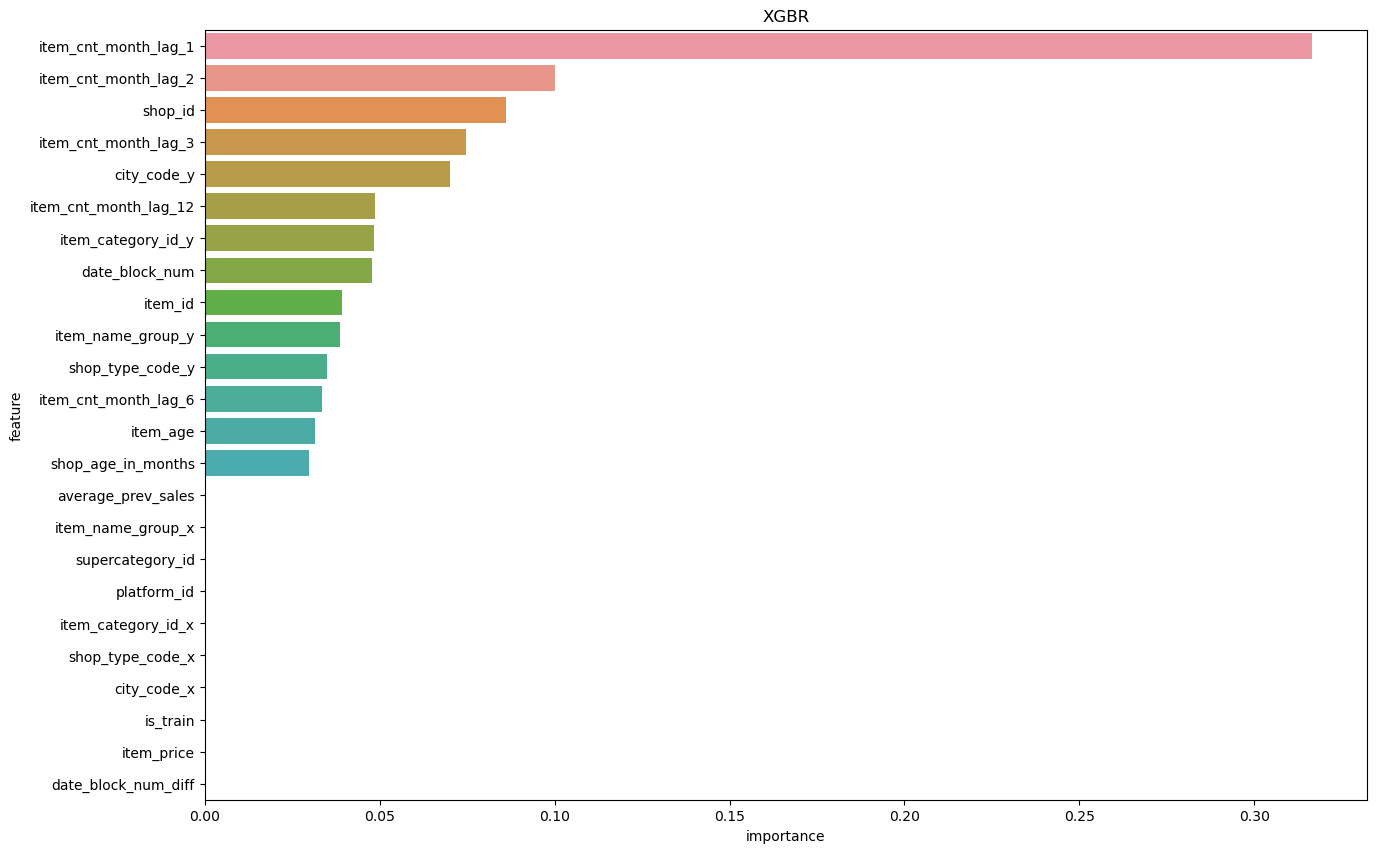

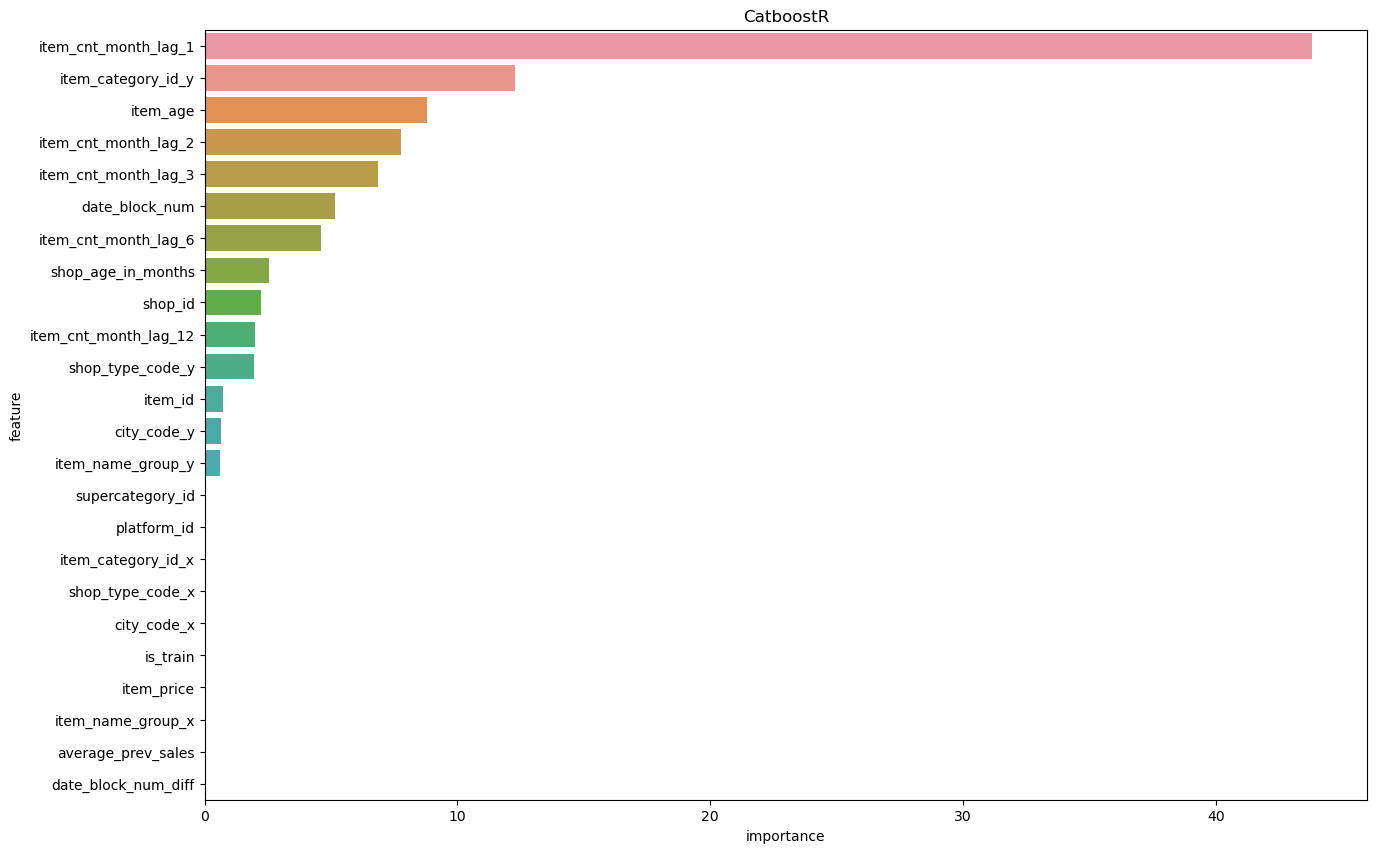

In [11]:
plot_feature_importance_layer(xgbr, train_x, 'XGBR')
plot_feature_importance_layer(catboostR, train_x, 'CatboostR')

In [12]:
del xgbr
del catboostR

### Optimization with hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.metrics import mean_squared_error
import time

from catboost import CatBoostRegressor
from xgboost import XGBRegressor


XGBoost_space = {'n_estimators': hp.randint('n_estimators', 100, 1000),
                 'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
                'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                'reg_alpha': hp.uniform('reg_alpha', 0, 1),
                'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                'booster': hp.choice('booster', ['gbtree', 'dart']),
                'tree_method':'gpu_hist', 
                 'gpu_id':0}

Catboost_space = {'iterations': hp.randint('iterations',100,1000),
               'depth': hp.randint('depth',4,10),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
               'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'loss_function': 'RMSE',
               'task_type': 'GPU'}

model_type = None

def operate(params):
    if model_type == 'XGBoost':
        model = XGBRegressor(**params)
    elif model_type == 'Catboost':
        model = CatBoostRegressor(**params)
    else:
        raise ValueError(f'Invalid model type: {model_type}')
    
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    mse = mean_squared_error(test_y, y_pred)
    return {'loss': mse, 'params': params, 'status': 'ok'}

best_params=dict()
start_time = time.time()
trials = Trials()
model_type = 'XGBoost'
del trials
trials = Trials()
best_XGBoost = fmin(operate, XGBoost_space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params['XGBoost'] = best_XGBoost
end_time = time.time()
elapsed_time = end_time - start_time
print('XGBoost')
print(best_params['XGBoost'])
print("XGBoost: {:.2f} seconds".format(elapsed_time))

start_time = time.time()
model_type = 'Catboost'
del trials
trials = Trials()
best_Catboost = fmin(operate, Catboost_space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params['Catboost'] = best_Catboost
end_time = time.time()
elapsed_time = end_time - start_time
del trials
print('Catboost')
print(best_params['Catboost'])
print("Catboost: {:.2f} seconds".format(elapsed_time))

100%|██████████| 10/10 [3:31:40<00:00, 1270.01s/trial, best loss: 20.751728057861328]
XGBoost
{'booster': 1, 'eta': 0.225, 'learning_rate': 0.02167728708583991, 'max_depth': 7, 'n_estimators': 567, 'reg_alpha': 0.45814199342290685, 'reg_lambda': 0.6254630444642293}
100%|██████████| 10/10 [16:30<00:00, 99.05s/trial, best loss: 20.501265054345115] 
Catboost
{'depth': 5, 'iterations': 632, 'l2_leaf_reg': 4, 'learning_rate': 0.17851674209081705}
Catboost: 990.49 seconds

100%|██████████| 10/10 [7:08:34<00:00, 2571.40s/trial, best loss: 21.089757919311523]
XGBoost
{'booster': 1, 'eta': 0.125, 'learning_rate': 0.036505013722635954, 'max_depth': 7, 'n_estimators': 682, 'reg_alpha': 0.06661942916103736, 'reg_lambda': 0.3959095054136891}
XGBoost: 25714.02 seconds


100%|██████████| 10/10 [15:47<00:00, 94.75s/trial, best loss: 20.562853328403193]
Catboost
{'depth': 5, 'iterations': 804, 'l2_leaf_reg': 2, 'learning_rate': 0.14249901722271482}
Catboost: 947.51 seconds

100%|██████████| 4/4 [06:50<00:00, 102.69s/trial, best loss: 20.144573211669922]
XGBoost
{'booster': 0, 'eta': 0.25, 'learning_rate': 0.017243201735748413, 'max_depth': 8, 'n_estimators': 459, 'reg_alpha': 0.20275084548059885, 'reg_lambda': 0.28498218455997115}

100%|██████████| 10/10 [13:30<00:00, 81.07s/trial, best loss: 19.77930069901141]
Catboost
{'depth': 6, 'iterations': 861, 'l2_leaf_reg': 8, 'learning_rate': 0.04317479764675777}
Catboost: 810.72 seconds

### Feature importance after optimization 

#### Train models

In [13]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
best_params=dict()
best_params['Catboost'] = {'depth': 5, 'iterations': 804, 'l2_leaf_reg': 2, 'learning_rate': 0.14249901722271482}
best_params['Catboost']['loss_function'] = 'RMSE'
best_params['Catboost']['verbose'] = 500
best_params['Catboost']['task_type'] = 'GPU'

In [14]:
CatBoostReg = CatBoostRegressor(**best_params['Catboost'])
CatBoostReg.fit(train_x, train_y)

0:	learn: 2.5085369	total: 105ms	remaining: 1m 24s
500:	learn: 1.5036873	total: 53.3s	remaining: 32.2s
803:	learn: 1.4676107	total: 1m 24s	remaining: 0us


In [15]:
best_params['XGBoost']=dict()
best_params['XGBoost'] = {'booster': 1, 'eta': 0.225, 'learning_rate': 0.02167728708583991, 'max_depth': 7, 'n_estimators': 567, 'reg_alpha': 0.45814199342290685, 'reg_lambda': 0.6254630444642293}
if best_params['XGBoost']['booster']==0:
    best_params['XGBoost']['booster'] = 'gbtree'
else:
    best_params['XGBoost']['booster'] = 'dart'
    
best_params['XGBoost']['tree_method'] = 'gpu_hist'

XGBReg = XGBRegressor(**best_params['XGBoost'])
XGBReg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.225,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02167728708583991, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=567, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.45814199342290685, ...)

#### XGBoost

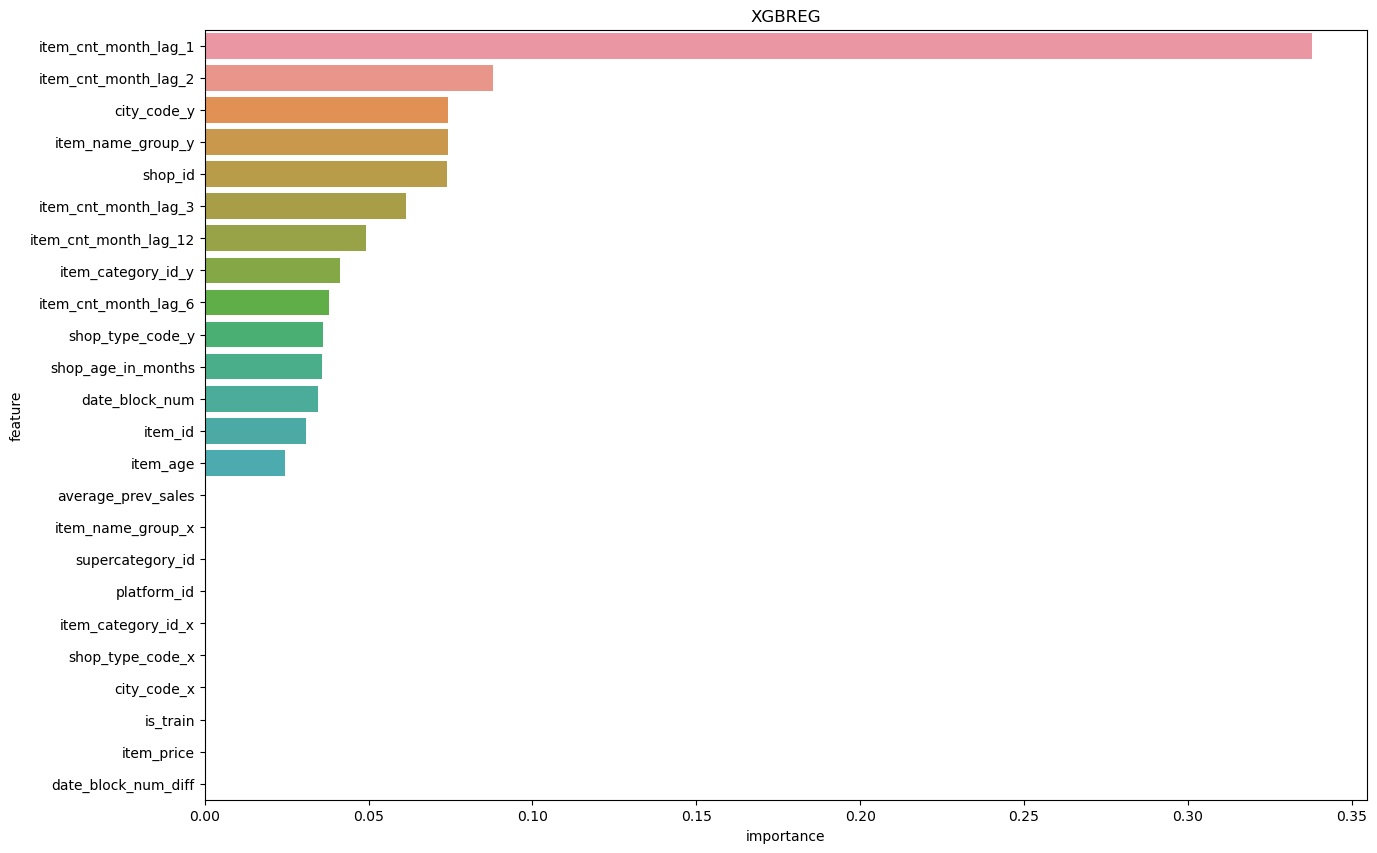

In [16]:
plot_feature_importance_layer(XGBReg, train_x, 'XGBREG')

#### Catboost

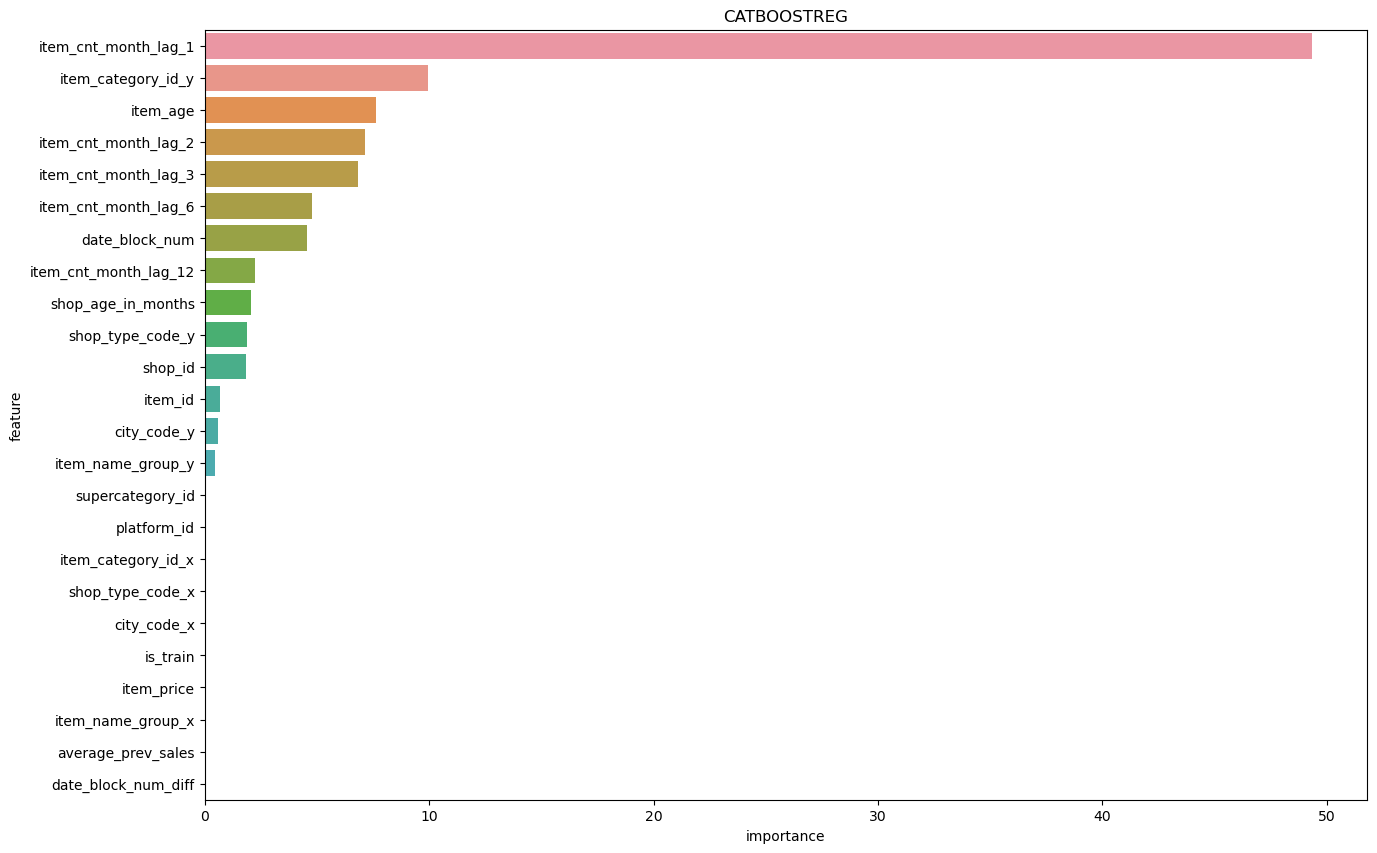

In [17]:
plot_feature_importance_layer(CatBoostReg, train_x, 'CATBOOSTREG')

### Explainability layer

In [18]:
import shap
shap.initjs()

train_xx = train_x[0:20000]
train_yy = train_y[0:20000]

test_xx = test_x[0:20000]
test_yy = test_y[0:20000]

In [19]:
def get_shap_val(model, test_x):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_x)
    return shap_values, explainer

In [20]:
def shap_summary_plot(test_x, shap_values):
    shap.summary_plot(shap_values, test_x)
    
def dec_plot(features_display,explainer , shap_values):
    shap.decision_plot(explainer.expected_value, shap_values, features_display)

### Error analysis layer

In [21]:
def show_infliental(shap_values, test_x, n_influential=20):
    highest_shap_indices = np.argsort(np.abs(shap_values))[-n_influential:]
    temp_df = pd.DataFrame()
    print("Samples that significantly influence the error rate:")
    for i in highest_shap_indices:
        temp_df = temp_df.append(test_x.iloc[i], ignore_index=True)
    from IPython.display import display
    display(temp_df.head(n_influential))
    del temp_df
    del highest_shap_indices

In [22]:
def plot_and_log(real_values, predicted_values):
    plt.scatter(real_values, predicted_values)
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs. Predicted Values")
    plt.show()

In [23]:
def plot_predicted_vs_real(predicted_values, real_values):
    bins = np.arange(0, 300, 2)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    predicted_means, _, _ = plt.hist(real_values, bins=bins, weights=predicted_values, density=True)
    
    predicted_stdevs, _, _ = plt.hist(real_values, bins=bins, weights=predicted_values**2, density=True)
    predicted_stdevs = np.sqrt(predicted_stdevs - predicted_means**2)
    
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 25))
    
    for i, ax in enumerate(axes.flat):
        start_idx = i * 10
        end_idx = (i + 1) * 10
        x_vals = bin_centers[start_idx:end_idx]
        y_vals = predicted_means[start_idx:end_idx]
        y_stdevs = predicted_stdevs[start_idx:end_idx]
        ax.errorbar(x_vals, y_vals, yerr=y_stdevs, fmt='o', color='red', capsize=5, capthick=2)
        ax.set_xlabel('Real Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'Subplot {i+1}')
    
    plt.show()

In [24]:
def plot_normalized_error(real_values, predicted_values, start, stop, step):
    
    bins = np.arange(start, stop, step)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    predicted_means, _, _ = plt.hist(real_values, bins=bins, weights=predicted_values, density=True)
    predicted_stdevs, _, _ = plt.hist(real_values, bins=bins, weights=predicted_values**2, density=True)
    predicted_stdevs = np.sqrt(predicted_stdevs - predicted_means**2)

    real_values_norm = (real_values - np.mean(real_values)) / np.std(real_values)
    predicted_values_norm = (predicted_values - np.mean(predicted_values)) / np.std(predicted_values)

    predicted_stdevs = np.repeat(predicted_stdevs, 2)

    predicted_stdevs_norm = np.std(predicted_values_norm)

    real_stdevs_norm = np.std(real_values_norm)

    plt.errorbar(real_values_norm, predicted_values_norm, yerr=predicted_stdevs_norm, fmt='o', color='red', capsize=5, capthick=2)

    plt.xlabel('Real Values (Normalized)')
    plt.ylabel('Predicted Values (Normalized)')
    plt.show()

In [25]:
#fixed
def plot_mean_predicted_values(predicted_values, real_values):
    df = pd.DataFrame({'real': real_values, 'predicted': predicted_values})
    grouped = df.groupby('real').mean()
    real_mean_predicted = grouped['predicted'].values
    real_bins = grouped.index.values
    num_subplots = int(np.ceil(len(real_bins) / 25))
    
    sns.set(style='ticks', font_scale=1.2, palette='Dark2')
    
    fig, axes = plt.subplots(nrows=num_subplots, ncols=1, figsize=(12, 8*num_subplots))
    
    for i in range(num_subplots):
        start_idx = i * 25
        end_idx = min((i + 1) * 25, len(real_bins))
        ax = axes[i]
        sns.lineplot(x=real_bins[start_idx:end_idx], y=real_mean_predicted[start_idx:end_idx], ax=ax)
        ax.set_xlabel('Real Values')
        ax.set_ylabel('Mean Predicted Values')
        ax.set_title(f'Subplot {i+1}')
        ax.grid()
    plt.show()

In [26]:
def rmse_operate(threshold_value, rmse):
    if rmse > threshold_value:
        print("Big target is poorly predicted.")
        print("Small dynamic is poorly predicted.")
    else:
        print("Big target is predicted well.")
        print("Small dynamic is predicted well.")
    
def get_rmse(predictions, test_y):
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    return rmse

## checker

# 😼Boost

In [27]:
pred = CatBoostReg.predict(test_x)
real_values = test_y

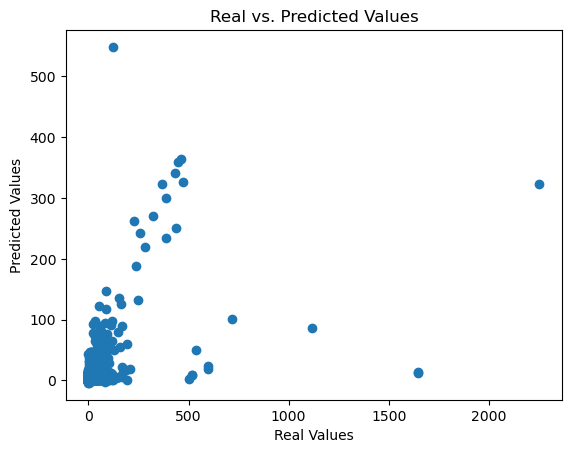

In [28]:
plot_and_log(predicted_values=pred, real_values=real_values)

invalid value encountered in sqrt


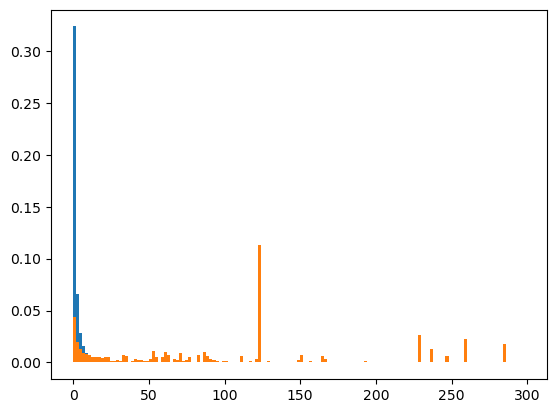

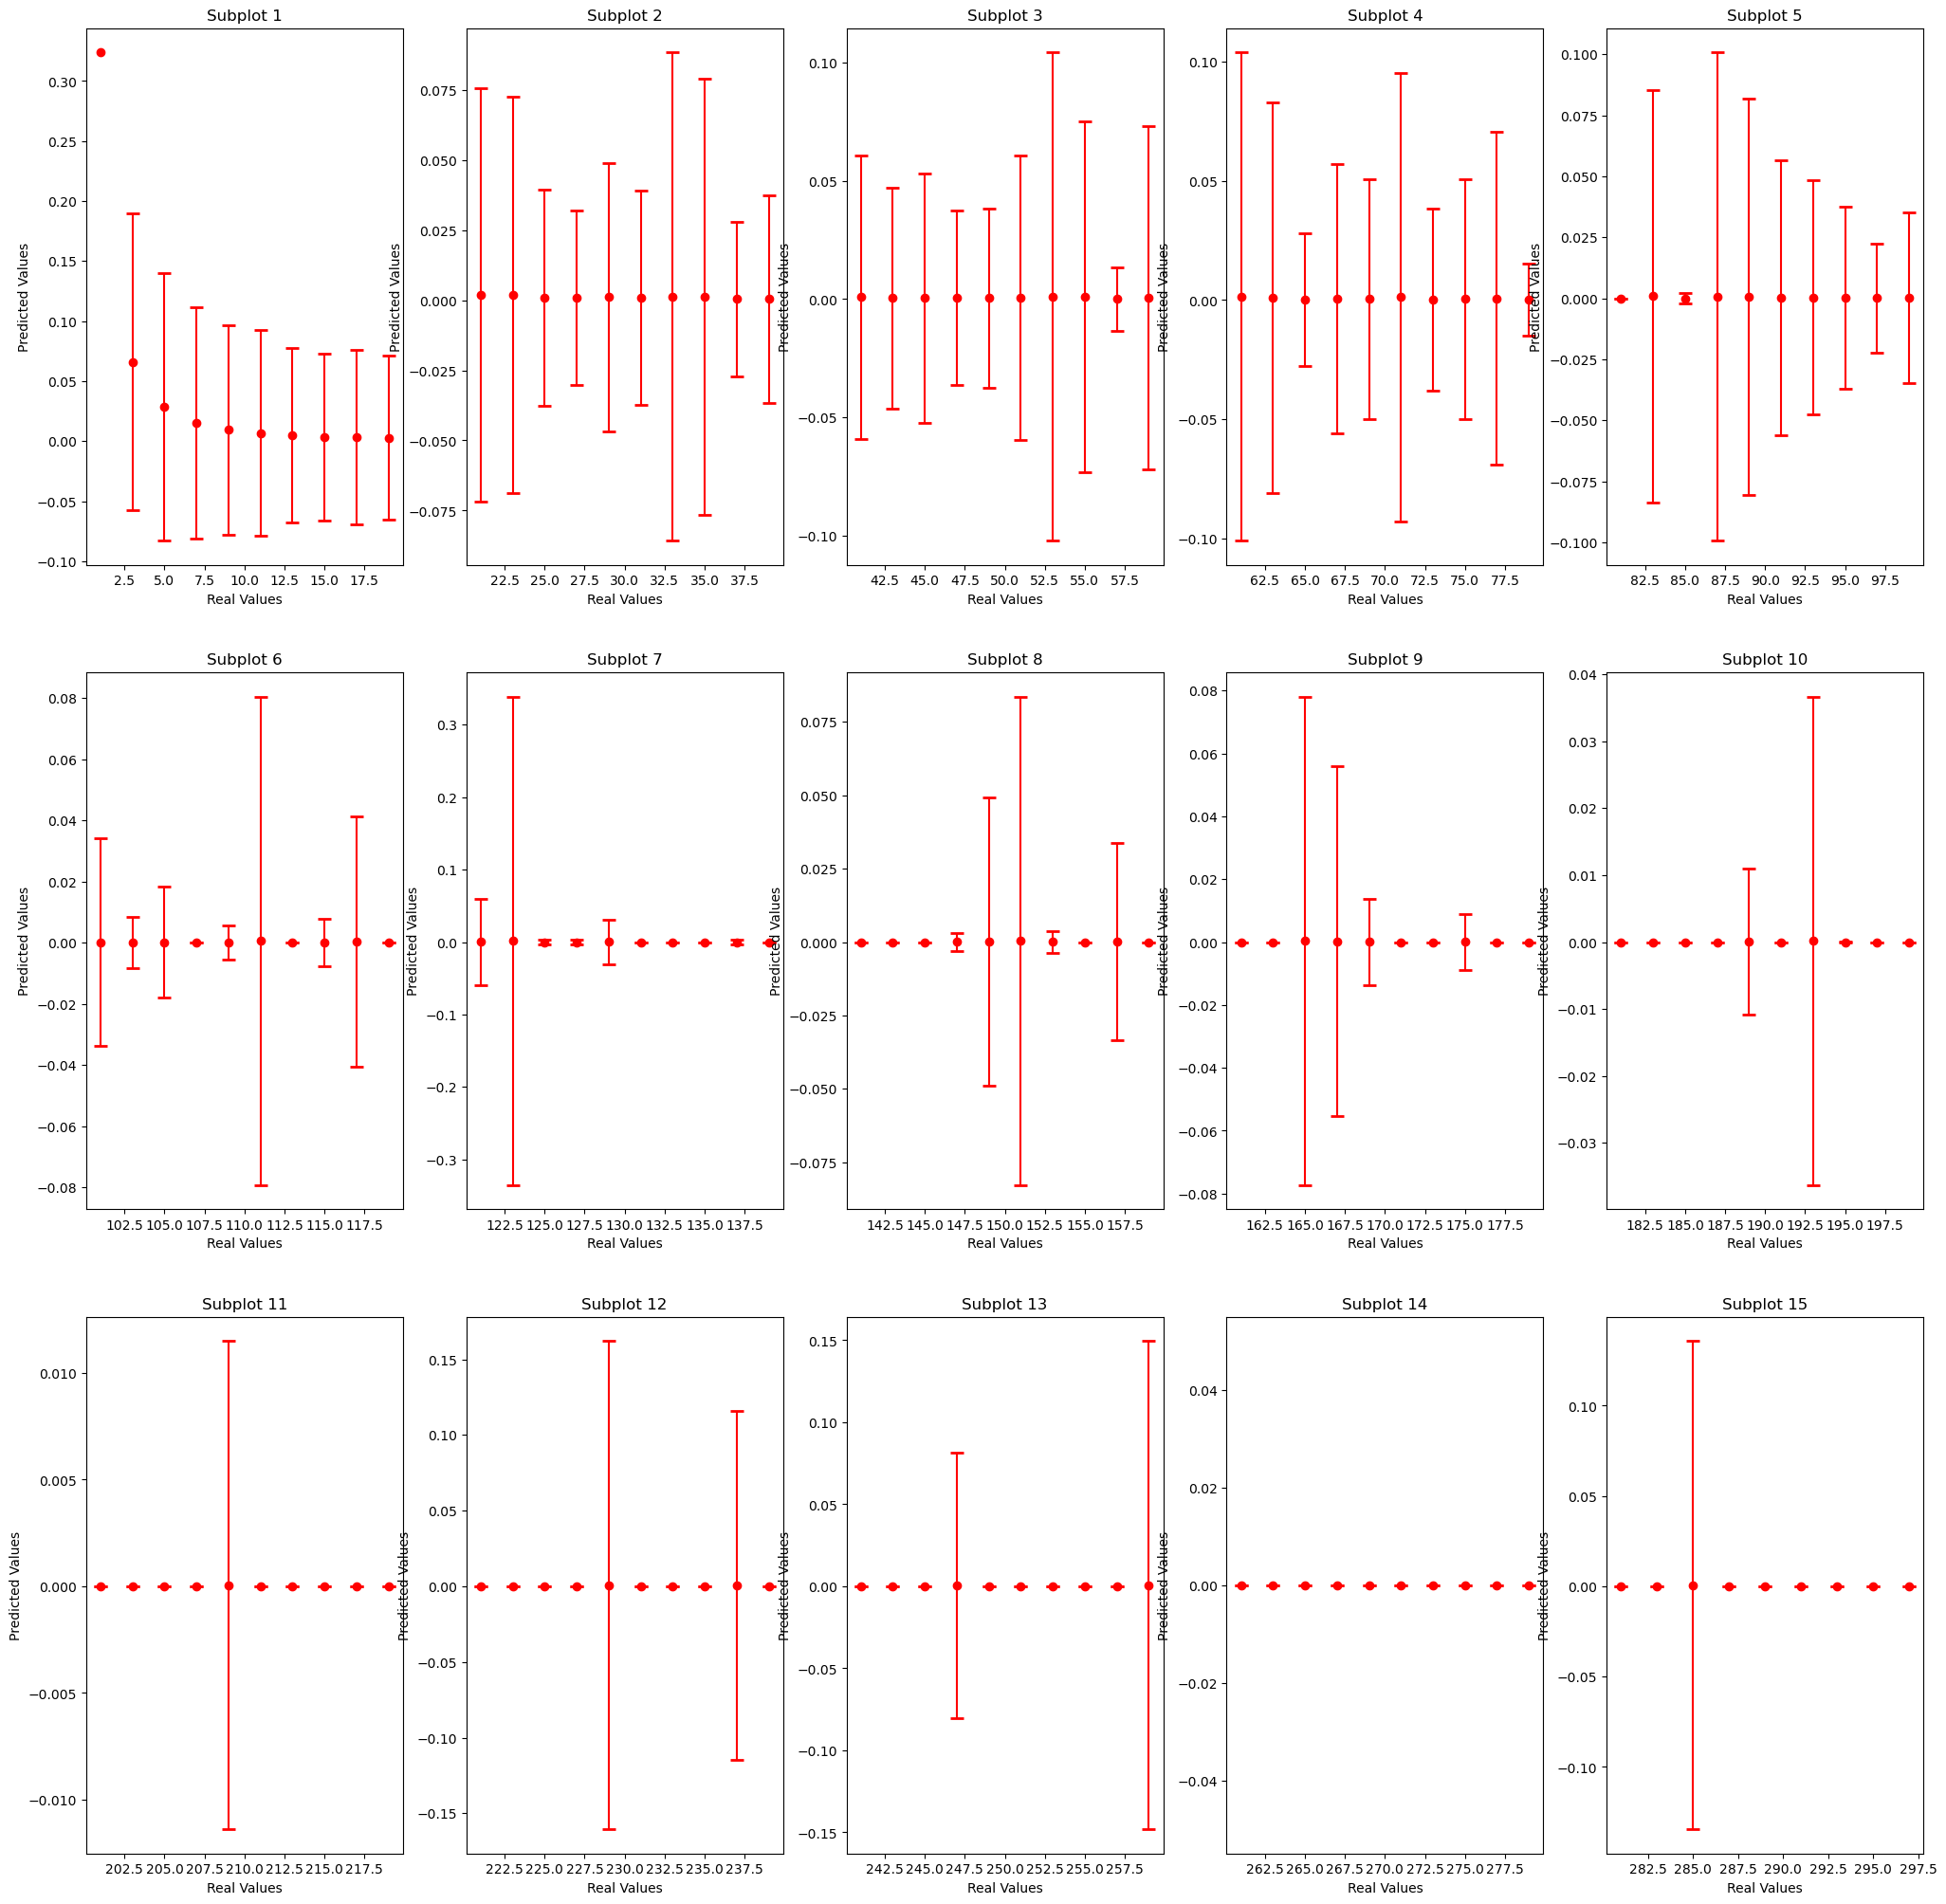

In [29]:
plot_predicted_vs_real(pred, real_values)

invalid value encountered in sqrt
All-NaN axis encountered
All-NaN axis encountered


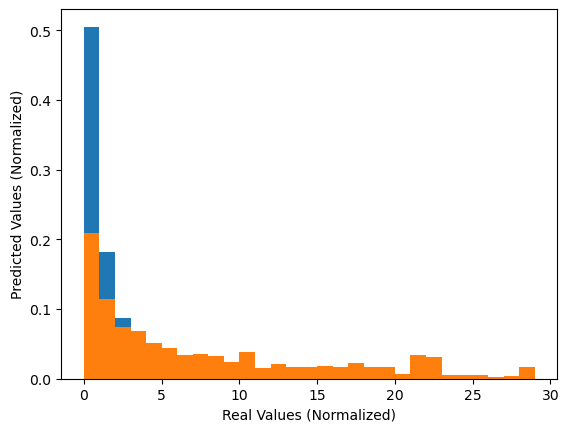

In [30]:
plot_normalized_error(real_values, pred, 0, 30, 1)

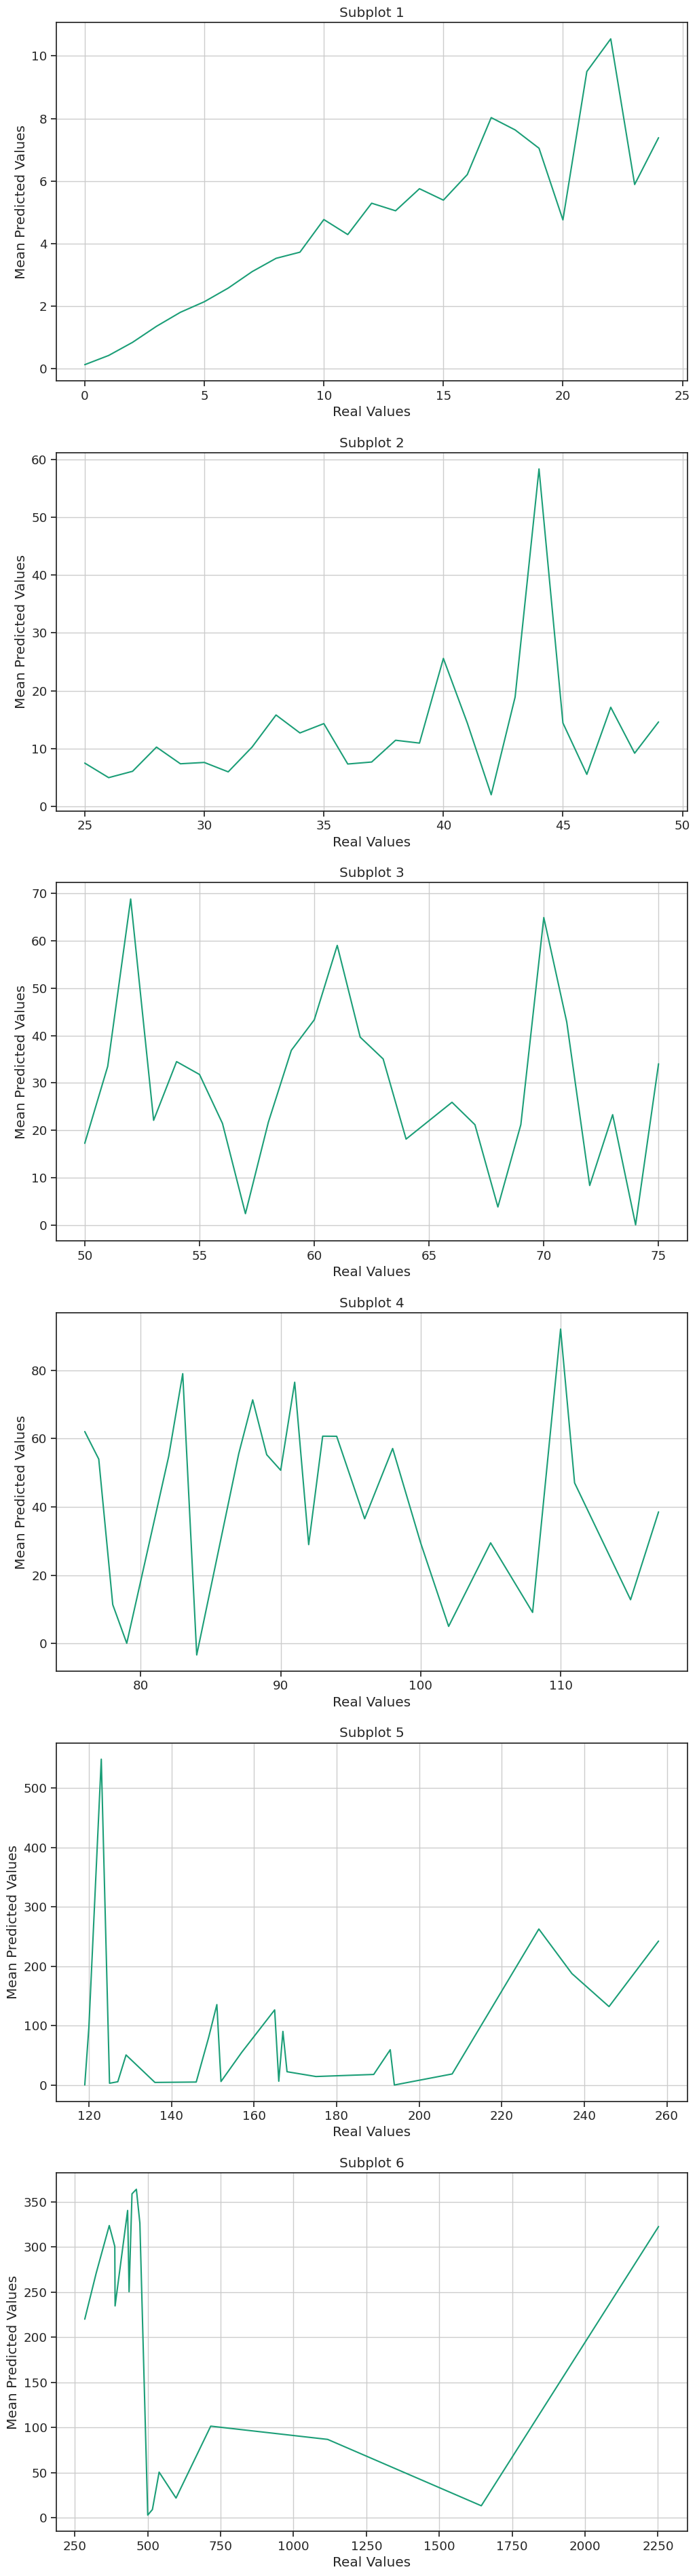

In [31]:
plot_mean_predicted_values(pred, real_values)

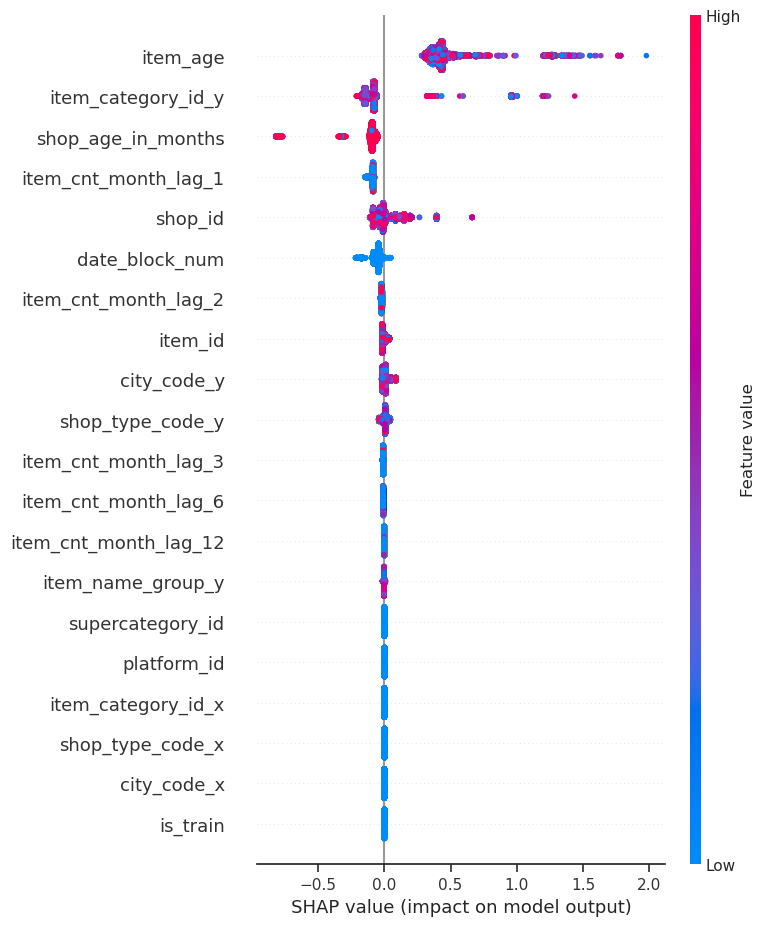

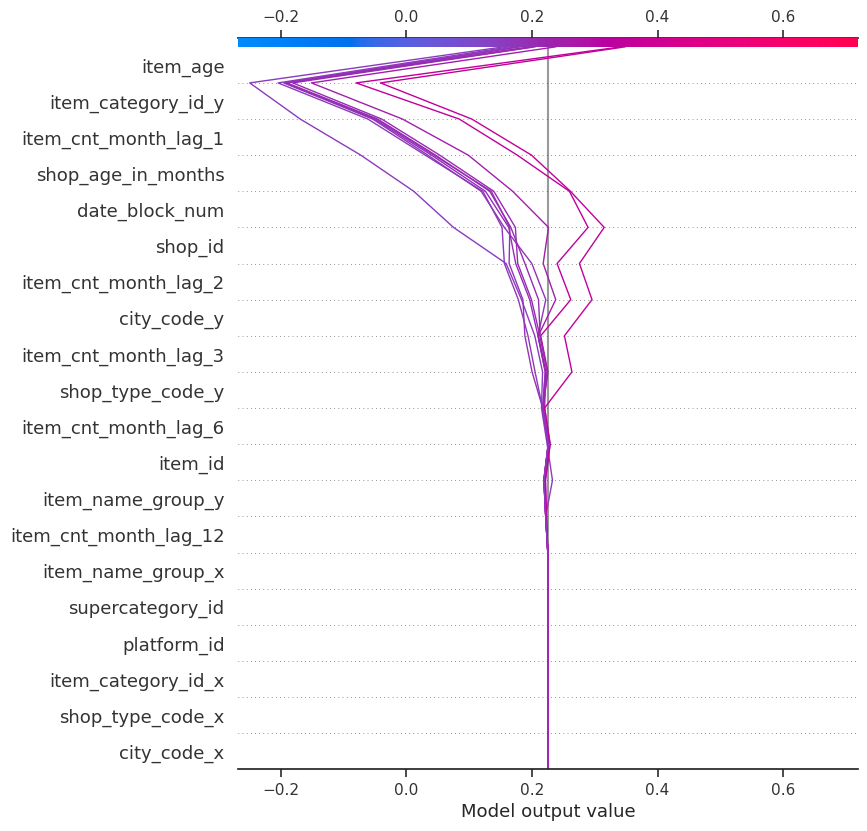

Samples that significantly influence the error rate:


,date_block_num,shop_id,item_id,item_price,is_train,city_code_x,shop_type_code_x,item_category_id_x,platform_id,supercategory_id,...,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_age_in_months,average_prev_sales,item_age,city_code_y,shop_type_code_y,item_category_id_y,item_name_group_y
0,31,37,20718,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,0,17,1,72,10198
1,31,35,20718,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,0,16,3,72,10198
2,31,24,20718,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,0,14,5,72,10198
3,31,44,20718,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,0,21,1,72,10198
4,31,37,17638,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,8,17,1,61,8584
5,31,35,17638,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,8,16,3,61,8584
6,31,50,8967,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,0,25,1,40,4285
7,31,46,20099,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,2,22,1,40,9887
8,31,38,17638,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,8,18,1,61,8584
9,31,42,20718,0,0,0,0,0,0,0,...,NaN,NaN,NaN,31,0,0,20,5,72,10198


Big target is poorly predicted.
Small dynamic is poorly predicted.


In [32]:
shap_values, explainer = get_shap_val(CatBoostReg, train_xx)
shap_summary_plot(test_xx, shap_values)
dec_plot(train_xx.columns, explainer, shap_values[:10])
show_infliental(shap_values, test_xx)
del shap_values
del explainer

predictions = CatBoostReg.predict(test_x)
rmse = get_rmse(predictions, test_y)
del predictions
rmse_operate(4, rmse)

### XGBoost

In [33]:
pred = XGBReg.predict(test_x)
real_values = test_y

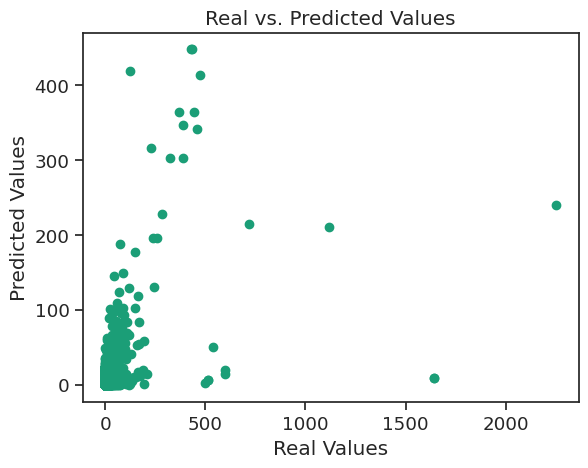

In [34]:
plot_and_log(predicted_values=pred, real_values=real_values)

invalid value encountered in sqrt


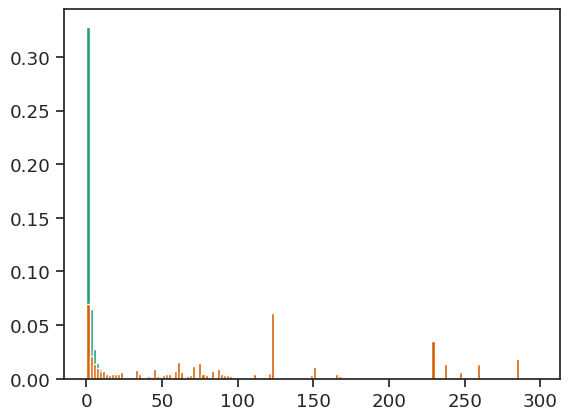

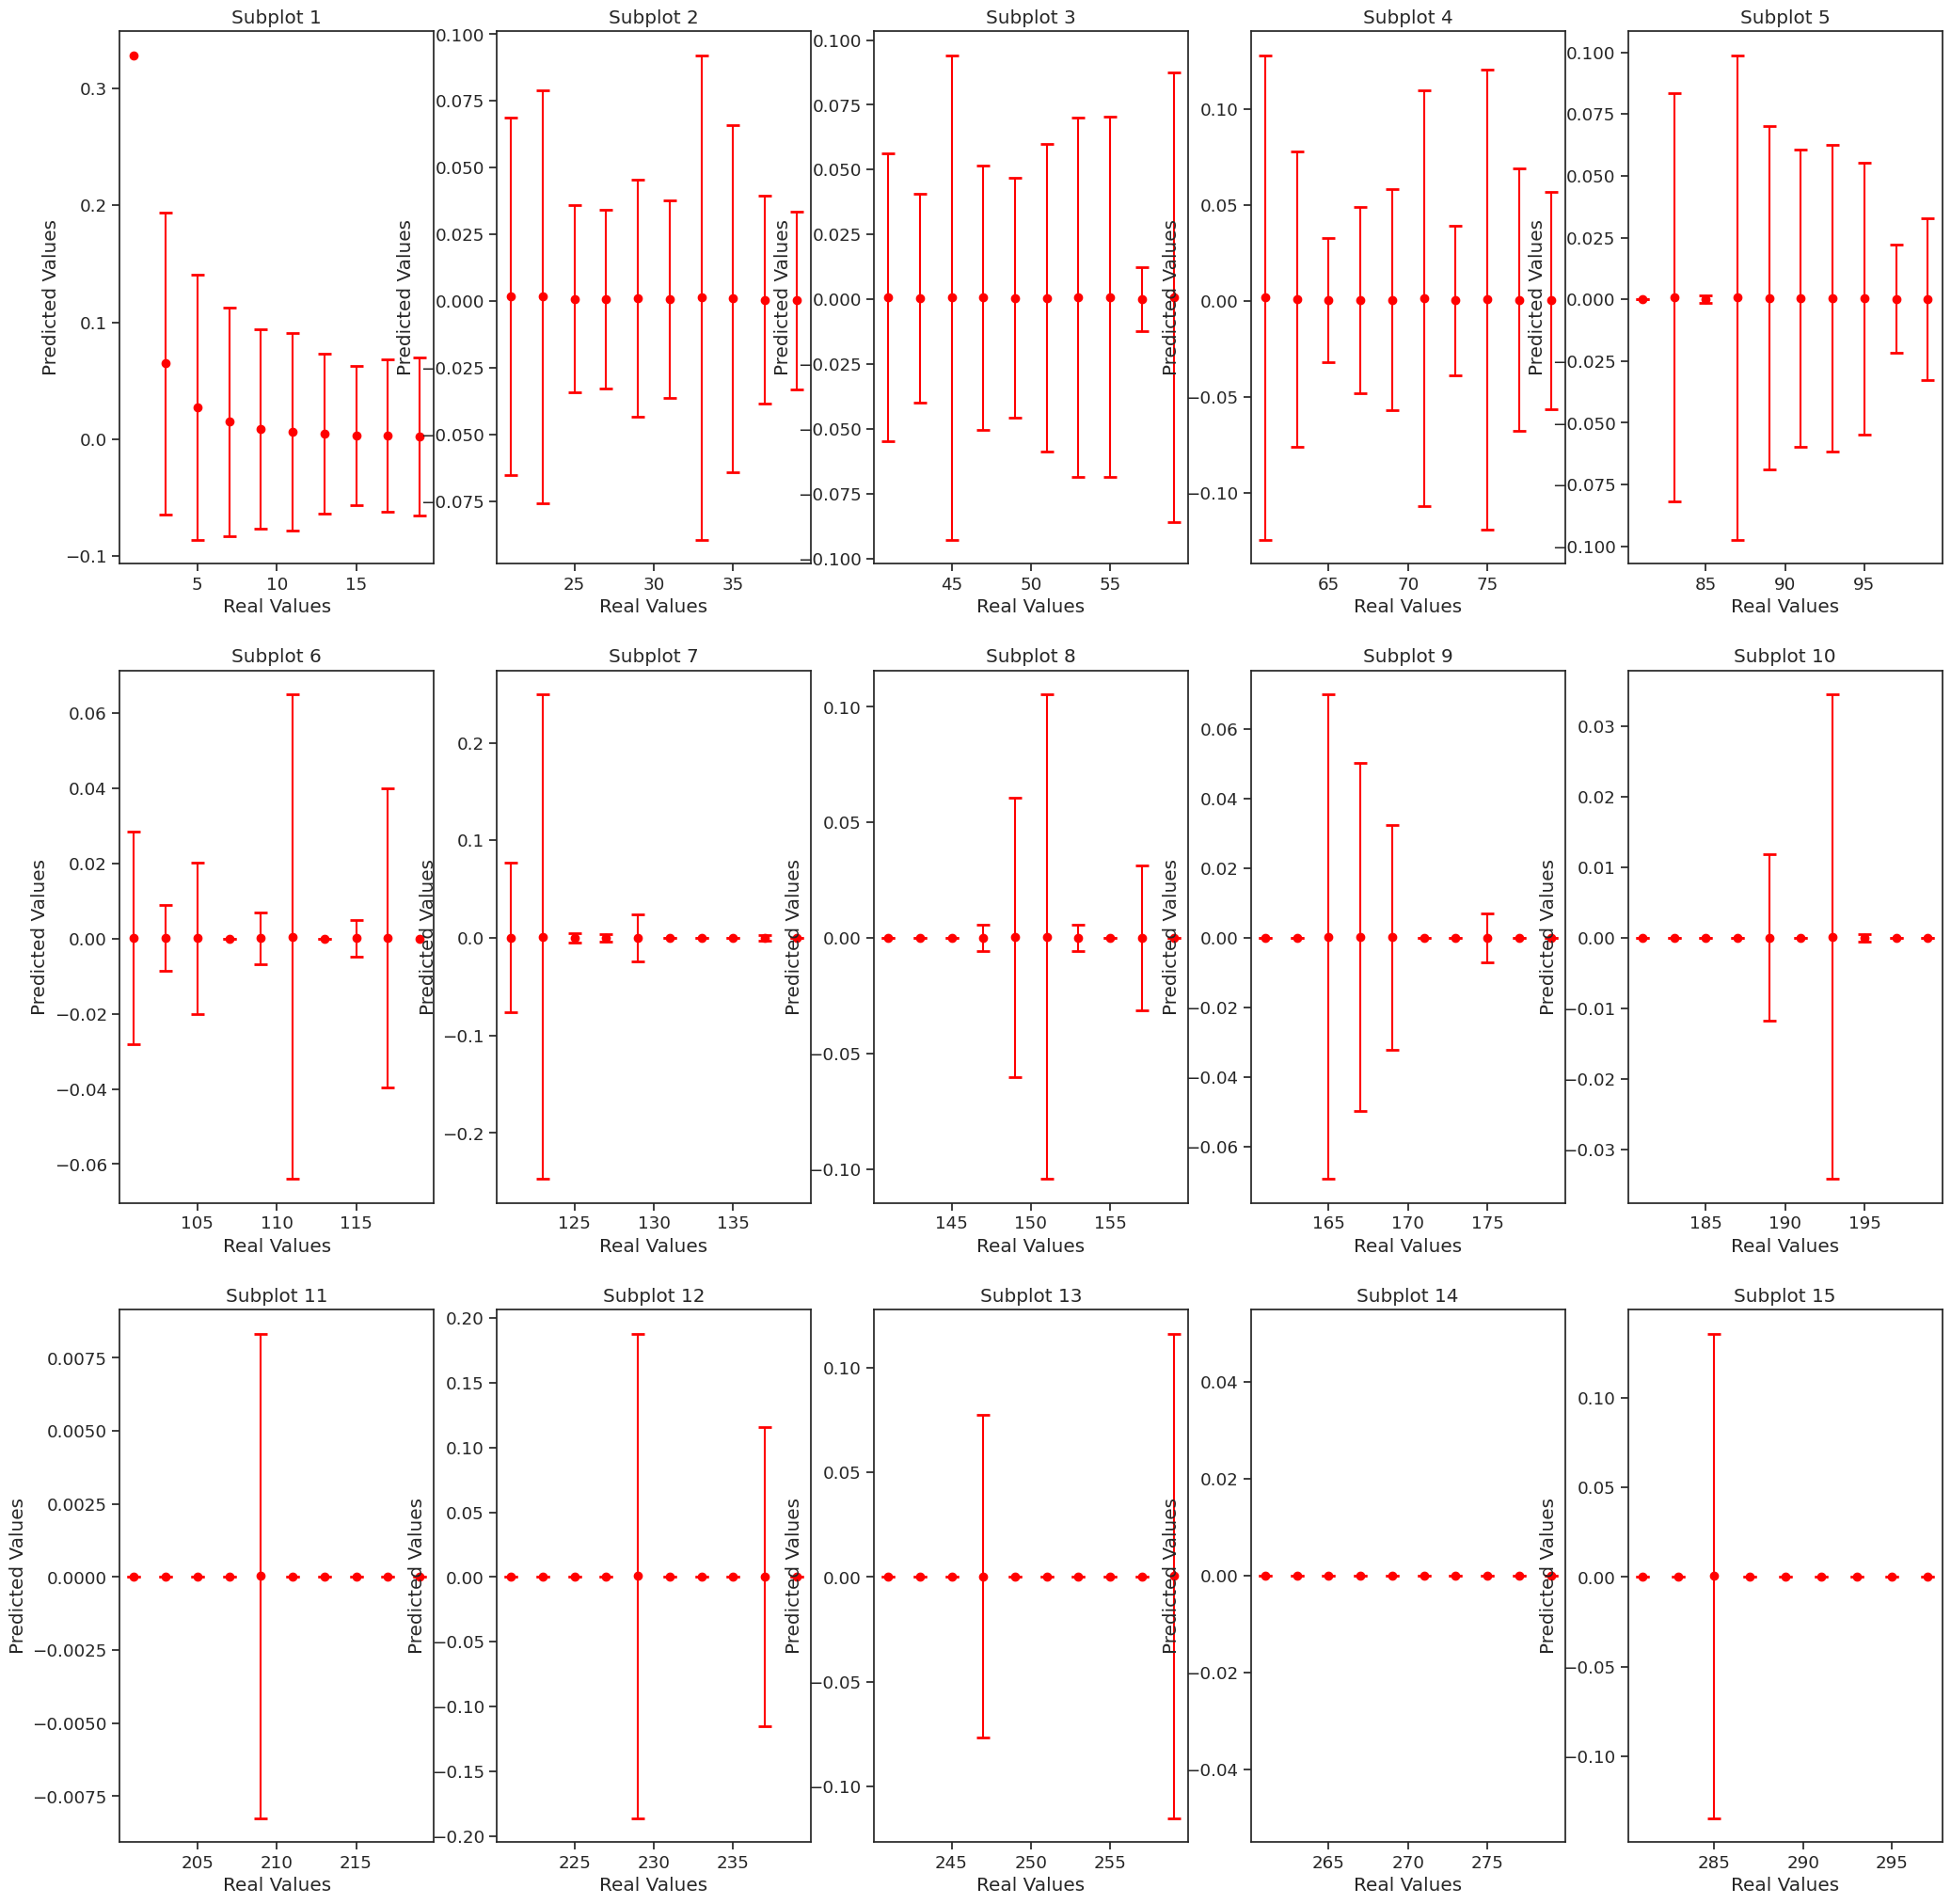

In [35]:
plot_predicted_vs_real(pred, real_values)

All-NaN axis encountered
All-NaN axis encountered


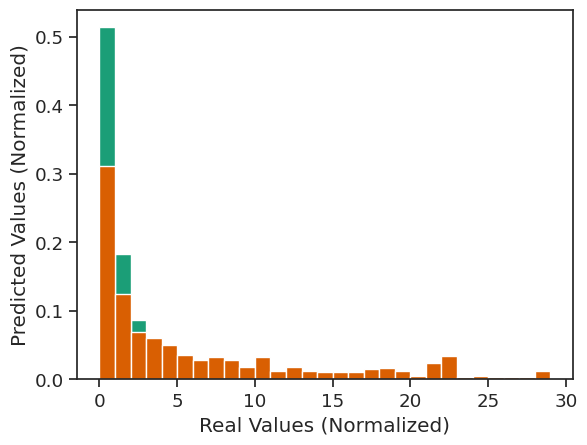

In [36]:
plot_normalized_error(real_values, pred, 0, 30, 1)

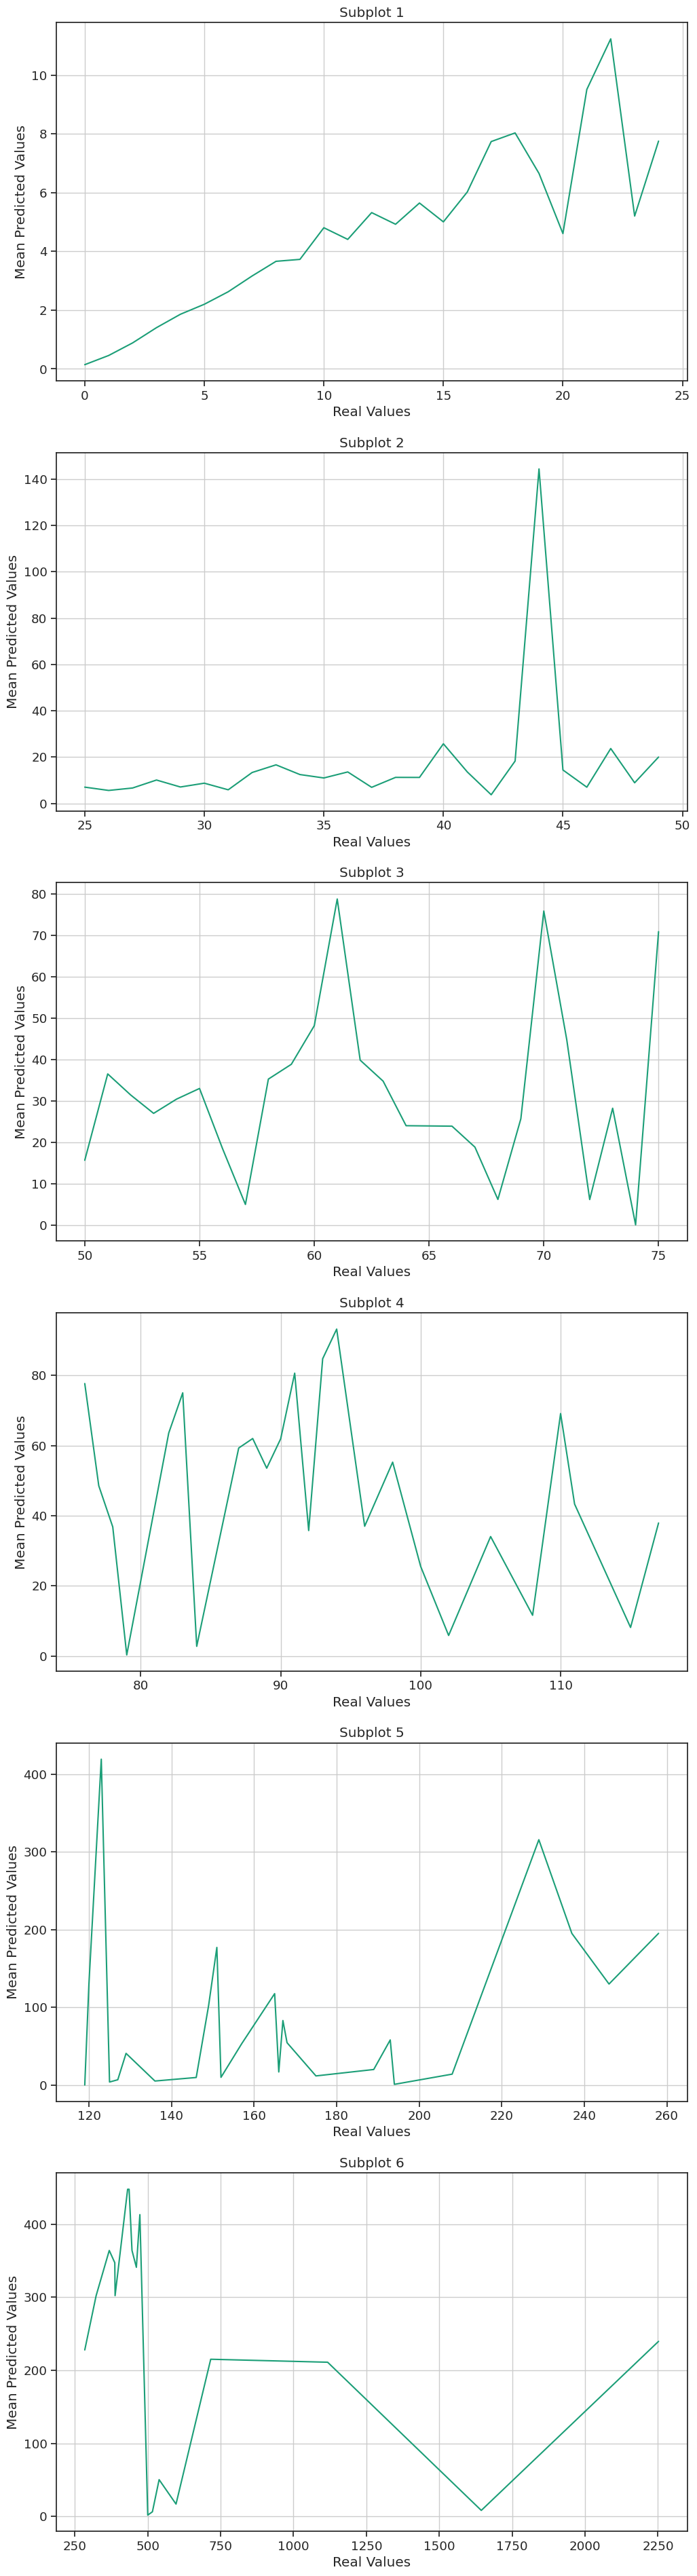

In [37]:
plot_mean_predicted_values(pred, real_values)

In [ ]:
shap_values, explainer = get_shap_val(XGBReg, train_xx)
shap_summary_plot(test_xx, shap_values)
dec_plot(train_xx.columns, explainer, shap_values[:10])
show_infliental(shap_values, test_xx)
del shap_values
del explainer

predictions = XGBReg.predict(test_x)
rmse = get_rmse(predictions, test_y)
del predictions
rmse_operate(4, rmse)

Big target is poorly predicted.
Small dynamic is poorly predicted